# Text Classification Task (CNN-Based Multiclass Sentiment Classification)

   
   # Objective:-
   - The goal is to classify the sentiment of McDonald's customer reviews into three categories:

     - #### Positive :- 4-5 stars
     - #### Neutral:-  3 stars
     - #### Negative:- 1-2 stars

     https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews/data

  

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!pip install scikeras

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras import Input
import seaborn as sns
from collections import Counter

In [4]:
df = pd.read_csv("McDonald_s_Reviews.csv", encoding = 'ISO-8859-1')
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


## Preprocessing the Dataset
#### This step extracts numeric ratings from text, cleans the rating column, and maps each rating to a sentiment category (positive, neutral, negative). Ratings 4-5 are labeled as positive, 3 as neutral, and 1-2 as negative, creating a new sentiment column for analysis.

In [6]:
df = df[["review", "rating"]].copy()
df["rating"] = df["rating"].astype(str)
df["rating"] = df["rating"].str.extract(r'(\d+)').astype(int)

def mapping(rating):
    if rating in [4,5]:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

# Applying the function
df["sentiment"] = df["rating"].apply(mapping)
df.head()

,review,rating,sentiment
0,Why does it look like someone spit on my food?...,1,negative
1,It'd McDonalds. It is what it is as far as the...,4,positive
2,Made a mobile order got to the speaker and che...,1,negative
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,positive
4,"I repeat my order 3 times in the drive thru, a...",1,negative


In [7]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

review       0
rating       0
sentiment    0
dtype: int64


## LabelEncoder to convert catergorical labels to numerical values
#### This step uses LabelEncoder to convert the sentiment categories (positive, neutral, negative) into numerical labels for machine learning models. The new column labels stores the encoded values.

In [8]:
label_encoder = LabelEncoder()
df["labels"] = label_encoder.fit_transform(df["sentiment"])
df.head()

,review,rating,sentiment,labels
0,Why does it look like someone spit on my food?...,1,negative,0
1,It'd McDonalds. It is what it is as far as the...,4,positive,2
2,Made a mobile order got to the speaker and che...,1,negative,0
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,positive,2
4,"I repeat my order 3 times in the drive thru, a...",1,negative,0


## WordNetLemmatizer instead of stemming, because it produces dictionary words to their base forms
#### This step tokenizes, lowercases, removes stopwords and non-alphabetic tokens, and lemmatizes each word in the review text. The cleaned output is stored in a new column mc_review for analysis.

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
        if not isinstance(text, str):
            return ""

        tokens = word_tokenize(text)
        cleaned_tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in tokens
        if word.isalpha() and word.lower() not in stop_words
    ]
        return " ".join(cleaned_tokens)

df["mc_review"] = df["review"].apply(clean_text)
df.head()

,review,rating,sentiment,labels,mc_review
0,Why does it look like someone spit on my food?...,1,negative,0,look like someone spit food normal transaction...
1,It'd McDonalds. It is what it is as far as the...,4,positive,2,mcdonalds far food atmosphere go staff make di...
2,Made a mobile order got to the speaker and che...,1,negative,0,made mobile order got speaker checked line mov...
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,positive,2,mc crispy chicken sandwich customer service qu...
4,"I repeat my order 3 times in the drive thru, a...",1,negative,0,repeat order time drive thru still manage mess...


# Feature Engineering

### I dropped review, rating and sentiment columns because the important features are labels and mc_review

In [10]:
df = df.drop(columns=["review", "rating", "sentiment"])
df.head()

,labels,mc_review
0,0,look like someone spit food normal transaction...
1,2,mcdonalds far food atmosphere go staff make di...
2,0,made mobile order got speaker checked line mov...
3,2,mc crispy chicken sandwich customer service qu...
4,0,repeat order time drive thru still manage mess...


In [11]:
# Checking class balance
df["labels"].value_counts()

,count
labels,
2,16061
0,12517
1,4818


### I splitted the dataset and changed the data into Numpy arrays.

#### Stratified train-validation-test split of the dataset based on the labels column, ensuring proportional representation of all classes. The data was divided into 64% training, 16% validation, and 20% test sets.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df[["mc_review"]],
    df["labels"],
    test_size=0.2,
    random_state = 42,
    stratify=df["labels"]
)


In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print("Training_set size:", len(X_train))
print("Validation_set size:", len(X_val))
print("Test set_size:", len(X_test))


Training_set size: 21372
Validation_set size: 5344
Test set_size: 6680


## Label Encoding and Data Conversion
##### Conversion of training, validation, and test splits from Pandas DataFrames and Series to NumPy arrays to ensure compatibility with downstream machine learning models and tokenization processes.

In [14]:
# The `labels` (y_train, y_val, y_test) are converted from Pandas Series to NumPy arrays for compatibility with Keras.
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

# One-hot encoding is applied using `to_categorical()` to prepare the labels for multiclass classification with a softmax output.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# The input feature sets (X_train, X_val, X_test) are also converted to NumPy arrays for model training.
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

### I used pretrained Glove embeddings to integrate into CNN model.
##### GloVe 100-dimensional embeddings (glove.6B.100d.txt) were loaded into a dictionary mapping words to their vector representations. This facilitates the conversion of textual input into numerical form for downstream NLP models.

In [16]:
def load_glove_embeddings(file_path, embedding_dim):
    embeddings_index = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefficients = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefficients
    return embeddings_index

embedding_dim = 100
glove_file_path = "glove.6B.100d.txt"
embeddings_index = load_glove_embeddings(glove_file_path, embedding_dim)
print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


### Tokenizing the training, validation and test datasets
##### The training data was tokenized using Keras' Tokenizer with a maximum vocabulary size of 10,000 words and an out-of-vocabulary (OOV) token. The tokenizer was fit on the training set and used to convert all text samples into sequences of integer word indices for model input.

In [17]:
max_vocab_size = 10000
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train.flatten())

X_train_seq = tokenizer.texts_to_sequences(X_train.flatten())
X_val_seq = tokenizer.texts_to_sequences(X_val.flatten())
X_test_seq = tokenizer.texts_to_sequences(X_test.flatten())


### Most frequent words of the review.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'food'),
  Text(1, 0, 'order'),
  Text(2, 0, 'service'),
  Text(3, 0, 'good'),
  Text(4, 0, 'mcdonald'),
  Text(5, 0, 'place'),
  Text(6, 0, 'get'),
  Text(7, 0, 'time'),
  Text(8, 0, 'one'),
  Text(9, 0, 'drive')])

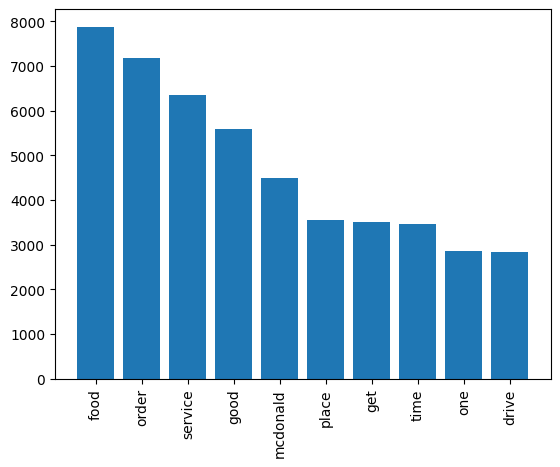

In [18]:
word_freq = Counter(" ".join(df['mc_review']).split())
common_words = word_freq.most_common(10)
words, counts = zip(*common_words)
plt.bar(words, counts)
plt.xticks(rotation=90)


### Padding and truncating to make sure that they have uniform inputs.
##### Tokenized input sequences were padded or truncated to a fixed length of 200 using Keras’ pad_sequences function. This ensures uniform input size across training, validation, and test sets, which is required for deep learning models.

In [19]:
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_val_pad = pad_sequences(X_val_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)


### Glove embeddings, to ensure that each word is mapped to its corresponding embedding.
##### An embedding matrix was constructed by aligning tokenizer-generated word indices with pre-trained GloVe embeddings. For each word within the defined vocabulary size (10,000), its corresponding 100-dimensional GloVe vector was inserted into the matrix. Words not found in the GloVe vocabulary were initialized as zero vectors.

In [20]:
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))

word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < max_vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


# Building The Model

### Here I use Convolutional Neural Network (CNN) design for multiclass classification task

In [21]:
# A 1D Convolutional Neural Network is used for sentiment classification. The model includes:

# - A pre-trained GloVe embedding layer
# - Two Conv1D layers with batch normalization and dropout
# - Global max pooling
# - Dense layers with ReLU and softmax for multiclass output

model_cnn = Sequential([
    Input(shape=(200,)),
    Embedding(
        input_dim=max_vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),

    Conv1D(filters=64, kernel_size=5, activation="relu", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),

    Conv1D(filters=64, kernel_size=5, activation="relu", kernel_regularizer=l2(0.01)),
    BatchNormalization(),

    GlobalMaxPooling1D(),

    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(3, activation="softmax", kernel_regularizer=l2(0.001))
])

model_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 196, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 196, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 196, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 192, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057,731 (4.03 MB)

 Trainable params: 1,057,347 (4.03 MB)

 Non-trainable params: 384 (1.50 KB)

### This class weights handles imbalanced datasets

In [22]:
y_train = np.array(y_train).flatten()

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
print("Class Weights:", class_weight_dict)

Class Weights: {np.int64(0): np.float64(0.8893882646691635), np.int64(1): np.float64(2.310736295815764), np.int64(2): np.float64(0.6930635275805039)}


# Model Training

In [23]:
# Define optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model with categorical crossentropy
model_cnn.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1
)

# Training the model using one-hot encoded labels
history_cnn = model_cnn.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weight_dict
)

Epoch 1/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 69s 93ms/step - accuracy: 0.4038 - loss: 3.1223 - val_accuracy: 0.4622 - val_loss: 2.5465 - learning_rate: 1.0000e-04
Epoch 2/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.4571 - loss: 2.7570 - val_accuracy: 0.5230 - val_loss: 2.3687 - learning_rate: 1.0000e-04
Epoch 3/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 80s 92ms/step - accuracy: 0.4856 - loss: 2.5639 - val_accuracy: 0.5728 - val_loss: 2.2223 - learning_rate: 1.0000e-04
Epoch 4/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 87s 100ms/step - accuracy: 0.5329 - loss: 2.3838 - val_accuracy: 0.6280 - val_loss: 2.0982 - learning_rate: 1.0000e-04
Epoch 5/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 78s 95ms/step - accuracy: 0.5585 - loss: 2.2718 - val_accuracy: 0.6707 - val_loss: 1.9734 - learning_rate: 1.0000e-04
Epoch 6/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 64s 95ms/step - accuracy: 0.6052 - loss: 2.1026 - val_accuracy: 0.6839 - val_loss: 1.8670 - learning_rate: 1.0000e-04
Epoch 7/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 86s 102ms/s

# Model Evaluation and Visualization

In [24]:
test_loss, test_accuracy = model_cnn.evaluate(X_test_pad, y_test_cat)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7394 - loss: 0.8550
Test Loss: 0.8555, Test Accuracy: 0.7425


##### The chart shows a steady increase in both training and validation accuracy, with minimal overfitting. Validation accuracy stabilizes around 75%, indicating good generalization and effective model regularization.

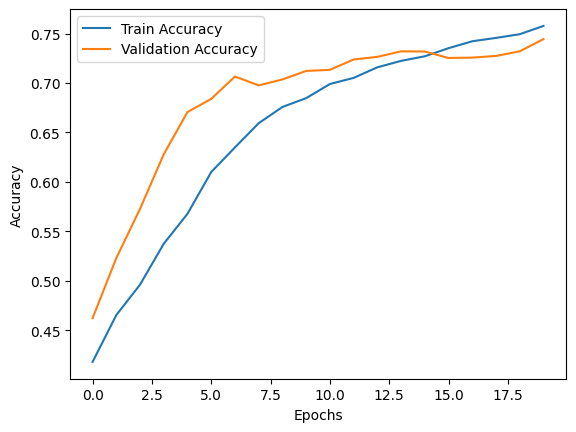

In [25]:
plt.plot(history_cnn.history["accuracy"], label="Train Accuracy")
plt.plot(history_cnn.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


##### Performance metrics of the CNN model on the test set. The model achieved an overall accuracy of 75%, with strong performance on the positive and negative classes. However, the neutral class showed lower precision (0.35), indicating a tendency for misclassification

    

In [26]:
# Predict class indices
y_pred = model_cnn.predict(X_test_pad).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
print(classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"]))


209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
              precision    recall  f1-score   support

    negative       0.88      0.72      0.79      2504
     neutral       0.35      0.65      0.46       964
    positive       0.89      0.78      0.83      3212

    accuracy                           0.74      6680
   macro avg       0.71      0.72      0.69      6680
weighted avg       0.81      0.74      0.76      6680



### This confusion matrix shows that high performance on positive and negative sentiments but misclassification for neutral class.

209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


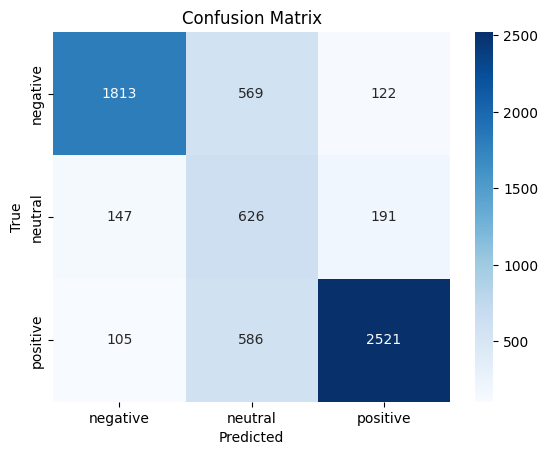

In [27]:
# Predict class labels
y_pred = model_cnn.predict(X_test_pad).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)

# Ploting confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### Sample predictions
#### New review texts are passed through the trained model to demonstrate real-world prediction capability. Predicted sentiments are labeled as negative, neutral, or positive.

In [28]:
sample_reviews = [
    "The burger was delicious, and the service was excellent!",
    "I waited for an hour, and my order was wrong. Terrible experience!",
    "The place is ok, but the food quality could be better."
]

sample_sequences = tokenizer.texts_to_sequences(sample_reviews)
sample_padded = pad_sequences(sample_sequences, maxlen=200, padding="post")
predictions = model_cnn.predict(sample_padded).argmax(axis=1)
label_to_sentiment = {0: "negative", 1: "neutral", 2: "positive"}
predicted_sentiments = [label_to_sentiment[p] for p in predictions]
for review, sentiment in zip(sample_reviews, predicted_sentiments):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Review: The burger was delicious, and the service was excellent!
Predicted Sentiment: positive

Review: I waited for an hour, and my order was wrong. Terrible experience!
Predicted Sentiment: negative

Review: The place is ok, but the food quality could be better.
Predicted Sentiment: neutral



# Conclusion
#### The model performs well on the positive and negative classes, achieving high accuracy and F1-scores. However, performance on the neutral class is lower, particularly in terms of precision, indicating that the model struggles to distinguish neutral reviews from the other categories. Overall test accuracy is around 75%.